In [1]:
playerInput = str(input("Input a player's full name (LeBron James): "))
player_name = ', '.join(playerInput.split(' ')[::-1])
seasonInput = str(input("Input a season (2015-16): "))

Input a player's full name (LeBron James): Kevin Durant
Input a season (2015-16): 2017-18


In [2]:
import pandas as pd
import NBAapi as nba
import numpy as np
from io import StringIO, BytesIO
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import urllib
from scipy import misc

%matplotlib inline

In [3]:
def shot_zone(X,Y):
    '''
    Uses shot coordinates x and y (in feet - divide by 10 if using the shotchart units)
    and returns a tuple with the zone location
    '''
    r = np.sqrt(X**2+Y**2)
    a = np.arctan2(Y,X)*180.0/np.pi
    if (Y<0) & (X > 0):
        a = 0
    elif (Y<0) & (X < 0):
        a = 180
    if r<=8:
        z = ('Less Than 8 ft.','Center(C)')
    elif (r>8) & (r<=16):
        if a < 60:
            z = ('8-16 ft.','Right Side(R)')
        elif (a>=60) & (a<=120):
            z = ('8-16 ft.','Center(C)')
        else:
            z = ('8-16 ft.','Left Side(L)')
    elif (r>16) & (r<=23.75):
        if a < 36:
            z = ('16-24 ft.','Right Side(R)')
        elif (a>=36) & (a<72):
            z = ('16-24 ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('16-24 ft.','Center(C)')
        elif (a>108) & (a<144):
            z = ('16-24 ft.','Left Side Center(LC)')
        else:
            z = ('16-24 ft.','Left Side(L)')
    elif r>23.75:
        if a < 72:
            z = ('24+ ft.','Right Side Center(RC)')
        elif (a>=72) & (a<=108):
            z = ('24+ ft.','Center(C)')
        else:
            z = ('24+ ft.','Left Side Center(LC)')
    if (np.abs(X)>=22):
        if (X > 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Right Side(R)')
        elif (X < 0) & (np.abs(Y)<8.75):
            z = ('24+ ft.','Left Side(L)')
        elif (X > 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Right Side Center(RC)')
        elif (X < 0) & (np.abs(Y)>=8.75):
            z = ('24+ ft.','Left Side Center(LC)')
    if Y >= 40:
        z = ('Back Court Shot', 'Back Court(BC)')
    return z

In [4]:
def players_picture(player_id):
    '''
    Input: player ID
    Output: players picture
    '''
    URL = "http://stats.nba.com/media/players/230x185/%d.png" %player_id
    file = BytesIO(urllib.request.urlopen(URL).read())
    return misc.imread(file)

In [5]:
player_list = nba.player.commonallplayers(currentseason=0) # load a list of NBA players including retired players 
player_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4285 entries, 0 to 4284
Data columns (total 13 columns):
PERSON_ID                   4285 non-null int64
DISPLAY_LAST_COMMA_FIRST    4285 non-null object
DISPLAY_FIRST_LAST          4285 non-null object
ROSTERSTATUS                4285 non-null int64
FROM_YEAR                   4285 non-null object
TO_YEAR                     4285 non-null object
PLAYERCODE                  4284 non-null object
TEAM_ID                     4285 non-null int64
TEAM_CITY                   4285 non-null object
TEAM_NAME                   4285 non-null object
TEAM_ABBREVIATION           4285 non-null object
TEAM_CODE                   4285 non-null object
GAMES_PLAYED_FLAG           4285 non-null object
dtypes: int64(3), object(10)
memory usage: 435.3+ KB


In [6]:
#player_name = 'Howard, Dwight' # identify player by name
player_id = player_list[player_list['DISPLAY_LAST_COMMA_FIRST']== player_name].PERSON_ID # get players id

# get shotchart for the player and the league average
shotchart,leagueavergae = nba.shotchart.shotchartdetail(playerid=player_id,season=seasonInput) 

# league average output contains more zones than we need. Let's reduce the it to the information we need
LA = leagueavergae.loc[:,'SHOT_ZONE_AREA':'FGM'].groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA']).sum()
LA['FGP'] = 1.0*LA['FGM']/LA['FGA'] # create new column with FG%

# get statistics per zone for the player from the shot chart information
player = shotchart.groupby(['SHOT_ZONE_RANGE','SHOT_ZONE_AREA','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
# create new column with FG%
player['FGP'] = 1.0*player.loc[:,1]/player.sum(axis=1)

In [7]:
player_vs_league = (player.loc[:,'FGP'] - LA.loc[:,'FGP'])*100 # compares player's FG% to league average
x,y = 0.1*shotchart.LOC_X.values, 0.1*shotchart.LOC_Y.values # get players shot coordinates

# get heetxbin to do the hard work for us. Use the extent and gridsize to get the desired bins
poly_hexbins = plt.hexbin(x,y, gridsize=35, extent=[-25,25,-6.25,50-6.25])

# get counts and vertices from histogram
counts = poly_hexbins.get_array()
verts = poly_hexbins.get_offsets()

# close figure since we are not interested in it
plt.close()

In [8]:
np.round(player_vs_league,1)

SHOT_ZONE_RANGE  SHOT_ZONE_AREA       
16-24 ft.        Center(C)                -1.8
                 Left Side Center(LC)     24.3
                 Left Side(L)              6.6
                 Right Side Center(RC)     4.6
                 Right Side(R)             5.0
24+ ft.          Center(C)                12.8
                 Left Side Center(LC)      6.2
                 Left Side(L)             16.7
                 Right Side Center(RC)     0.1
                 Right Side(R)            14.6
8-16 ft.         Center(C)                 8.2
                 Left Side(L)              3.8
                 Right Side(R)            13.1
Back Court Shot  Back Court(BC)           -1.4
Less Than 8 ft.  Center(C)                11.7
Name: FGP, dtype: float64

Text(20,27.5,'2017-18')

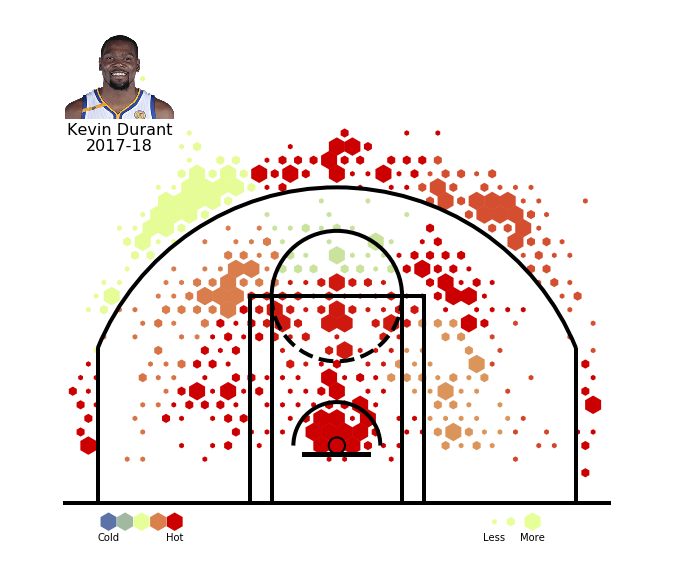

In [9]:
# create figure plot
plt.figure(figsize=(12,10),facecolor='white') 
ax = plt.gca(xlim = [30,-30],ylim = [-10,40],xticks=[],yticks=[],aspect=1.0)
#plt.text(0,-7,'By: Doingthedishes',color='black',horizontalalignment='center',fontsize=20,fontweight='bold')
nba.plot.court(ax,outer_lines=False,color='black',lw=4.0,direction='down')
ax.axis('off')
 
s = 0.85 # scaling factor for hexagons

# FG% bins from -9 to 9. I'm using 200 bins to make the color scale more continous. This is my personal preference. 
# I think that this is not the case with the Grantland shot charts
bins = np.concatenate([[-np.inf],np.linspace(-9,9,200),[np.inf]]) 

# choose color scheme. I choose colors that are similar to the ones in Grantland
colors = [(0.36, 0.45, 0.66),(0.9,1.0,0.6), (0.8, 0, 0)]
cm = LinearSegmentedColormap.from_list('my_list', colors, N=len(bins)-1) # create linear color scheme

# create hexagons
xy = s*np.array([np.cos(np.linspace(np.pi/6,np.pi*330/180,6)),np.sin(np.linspace(np.pi/6,np.pi*330/180,6))]).T
b = np.zeros((6,2))
# adjust size scaling factor depending on the frequency of shots. Size-frequency relationship was choosen empirically 
counts_norm = np.zeros_like(counts)
counts_norm[counts>=4] = 1 # 4 shots or more= full size hexagon
counts_norm[(counts>=2) & (counts<4)] = 0.5 # 2 or 3 shots = half size hexagon 
counts_norm[(counts>=1) & (counts<2)] = 0.3 # 1 shot = small hexagon

# start creating patch and color list
patches=[]
colors=[]
# loop over vertices
for offc in range(verts.shape[0]):
    if counts_norm[offc] != 0:
        xc,yc = verts[offc][0],verts[offc][1] # vertex center 
        b[:,0] = xy[:,0]*counts_norm[offc] + xc # hexagon x coordinates
        b[:,1] = xy[:,1]*counts_norm[offc] + yc # hexagon y coordinates
        p_diff = player_vs_league.loc[shot_zone(xc,yc)] # FG% difference for the specific zone
        inds = np.digitize(p_diff, bins,right=True)-1 # convert FG% difference to color index  
        patches.append(Polygon(b))
        colors.append(inds)

# create colorbar 
for i in range(5):
    xc = 21-2*0.76*i
    yc = -7
    b[:,0] = xy[:,0] + xc
    b[:,1] = xy[:,1] + yc
    patches.append(Polygon(b))
    colors.append(i*50)
plt.text(21,-8.5,'Cold',horizontalalignment='center',verticalalignment='center')
plt.text(21-2*0.76*4,-8.5,'Hot',horizontalalignment='center',verticalalignment='center')

# create frequency illustration
xc = -14.5
yc = -7.0
plt.text(xc,-8.5,'Less',horizontalalignment='center',verticalalignment='center')
b[:,0] = xy[:,0]*0.3 + xc
b[:,1] = xy[:,1]*0.3 + yc
patches.append(Polygon(b))
colors.append(100)
xc = -16
b[:,0] = xy[:,0]*0.50 + xc
b[:,1] = xy[:,1]*0.50 + yc
patches.append(Polygon(b))
colors.append(100)
xc = -18
b[:,0] = xy[:,0] + xc
b[:,1] = xy[:,1] + yc
plt.text(xc,-8.5,'More',horizontalalignment='center',verticalalignment='center')

patches.append(Polygon(b))
colors.append(100)

# plot all patches
p = PatchCollection(patches,cmap=cm,alpha=1)
p.set_array(np.array(colors))
ax.add_collection(p)
p.set_clim([0, len(bins)-1])

# include player's picture
pic = players_picture(player_id)
plt.imshow(pic,extent=[15,25,30,38])
plt.text(20,29,' '.join(player_name.split(',')[::-1]).strip(),fontsize=16,horizontalalignment='center',verticalalignment='center')
plt.text(20,27.5,seasonInput,fontsize=16,horizontalalignment='center',verticalalignment='center')